In [10]:
import sys
import math
import pandas as pd
import numpy as np

def read_elem(filename):
    with open(filename) as f:
        return [str(elem) for elem in f.read().split()]

# The input files follow the "Solomon" format.
def read_input_cvrptw(filename):
    file_it = iter(read_elem(filename))

    for i in range(4): next(file_it)

    nb_trucks = int(next(file_it))
    truck_capacity = int(next(file_it))

    for i in range(13): next(file_it)

    warehouse_x = int(next(file_it))
    warehouse_y = int(next(file_it))

    for i in range(2): next(file_it)

    max_horizon = int(next(file_it))

    next(file_it)

    customers_x = []
    customers_y = []
    demands = []
    earliest_start = []
    latest_end = []
    service_time = []

    while (1):
        val = next(file_it, None)
        if val is None: break
        i = int(val) - 1
        customers_x.append(int(next(file_it)))
        customers_y.append(int(next(file_it)))
        demands.append(int(next(file_it)))
        ready = int(next(file_it))
        due = int(next(file_it))
        stime = int(next(file_it))
        earliest_start.append(ready)
        latest_end.append(due + stime)  # in input files due date is meant as latest start time
        service_time.append(stime)

    nb_customers = i + 1

    # Compute distance matrix
    distance_matrix = compute_distance_matrix(customers_x, customers_y)
    distance_warehouses = compute_distance_warehouses(warehouse_x, warehouse_y, customers_x, customers_y)

    return (nb_customers, nb_trucks, truck_capacity, distance_matrix, distance_warehouses, demands, service_time,
            earliest_start, latest_end, max_horizon, warehouse_x, warehouse_y, customers_x, customers_y)


# Computes the distance matrix
def compute_distance_matrix(customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(customers_x[i], customers_x[j], customers_y[i], customers_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


# Computes the distances to warehouse
def compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_warehouses = [None] * nb_customers
    for i in range(nb_customers):
        dist = compute_dist(depot_x, customers_x[i], depot_y, customers_y[i])
        distance_warehouses[i] = dist
    return distance_warehouses


def compute_dist(xi, xj, yi, yj):
    return math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))

In [21]:
# depots = dat.depots1
# LOCATION_NAME   LATITUDE   LONGITUDE  TIME_WINDOW_START  TIME_WINDOW_END  MAXIMUM_CAPACITY

# customers = dat.customers1
# LOCATION_NAME   LATITUDE   LONGITUDE  STOP_TIME  TIME_WINDOW_START  TIME_WINDOW_END  DEMAND

# transportation_matrix = dat.transportation_matrix1
# FROM_LOCATION_NAME TO_LOCATION_NAME  FROM_LATITUDE  FROM_LONGITUDE  TO_LATITUDE  TO_LONGITUDE  DRIVE_MINUTES  HAVERSINE_DISTANCE_MILES  TRANSPORTATION_COST

# vehicles = dat.vehicles1.head(15)
# VEHICLE_NAME  CAPACITY  VEHICLE_FIXED_COST

# capacity = vehicles.iloc[0, :]['CAPACITY']

def solomon2df(nb_customers, nb_trucks, truck_capacity, distance_matrix, distance_warehouses, demands, service_time,
                earliest_start, latest_end, max_horizon, warehouse_x, warehouse_y, customers_x, customers_y):
    depots = pd.DataFrame(data={"LOCATION_NAME": ["depot"],
                                "LATITUE": [warehouse_x], "LONGITUDE": [warehouse_y],
                                "TIME_WINDOW_START": [0], "TIME_WINDOW_END": [max_horizon],
                                "MAXIMUM_CAPACITY": [5*np.sum(demands)]})
    customers_data = []
    customer_names = []
    for i in range(nb_customers):
        customer_names.append(f"Customer_{i}")
        customers_data.append([f"Customer_{i}", customers_x[i], customers_y[i], service_time[i],
                                 earliest_start[i],  latest_end[i], demands[i]])
    customers = pd.DataFrame(data=customers_data, columns="LOCATION_NAME   LATITUDE   LONGITUDE  STOP_TIME  TIME_WINDOW_START  TIME_WINDOW_END  DEMAND".split())
    transportation_matrix_data = []
    for i in range(nb_customers):
        for j in range(nb_customers):
            transportation_matrix_data.append([customer_names[i], customer_names[j],
                                               customers_x[i], customers_y[i],
                                               customers_x[j], customers_y[j],
                                               0, 0, distance_matrix[i][j]])
        transportation_matrix_data.append([customer_names[i], "depot",
                                            customers_x[i], customers_y[i],
                                            warehouse_x, warehouse_y,
                                            0, 0, distance_warehouses[i]])
        transportation_matrix_data.append(["depot", customer_names[i],
                                            warehouse_x, warehouse_y,
                                            customers_x[i], customers_y[i],
                                            0, 0, distance_warehouses[i]])

    transportation_matrix = pd.DataFrame(data=transportation_matrix_data, columns="FROM_LOCATION_NAME TO_LOCATION_NAME  FROM_LATITUDE  FROM_LONGITUDE  TO_LATITUDE  TO_LONGITUDE  DRIVE_MINUTES  HAVERSINE_DISTANCE_MILES  TRANSPORTATION_COST".split())
    vehicles_data = []
    for i in range(nb_trucks):
        vehicles_data.append([f"vehicle_{i}", truck_capacity, 1])
    vehicles = pd.DataFrame(data=vehicles_data, columns="VEHICLE_NAME  CAPACITY  VEHICLE_FIXED_COST".split())
    return depots, customers, transportation_matrix, vehicles
    

In [8]:
problem_file = "/data/songlei/cvrptw-optimization/cvrp_benchmarks/homberger_400_customer_instances/C1_4_2.TXT"
(nb_customers, nb_trucks, truck_capacity, distance_matrix, distance_warehouses, demands, service_time,
            earliest_start, latest_end, max_horizon, warehouse_x, warehouse_y, customers_x, customers_y) = read_input_cvrptw(problem_file)

In [22]:
depots, customers, transportation_matrix, vehicles = solomon2df(nb_customers, nb_trucks, truck_capacity, distance_matrix, distance_warehouses, demands, service_time,
            earliest_start, latest_end, max_horizon, warehouse_x, warehouse_y, customers_x, customers_y)
capacity = vehicles.iloc[0, :]['CAPACITY']

print("depots:", depots)
print("customers: ", customers)
print("transportation_matrix: ", transportation_matrix)
print("vehicles: ", vehicles)



depots:   LOCATION_NAME  LATITUE  LONGITUDE  TIME_WINDOW_START  TIME_WINDOW_END  \
0         depot      100        100                  0             1501   

   MAXIMUM_CAPACITY  
0             35950  
customers:      LOCATION_NAME  LATITUDE  LONGITUDE  STOP_TIME  TIME_WINDOW_START  \
0      Customer_0       181        172         90                348   
1      Customer_1       154         31         90                795   
2      Customer_2       123        106         90                747   
3      Customer_3        23        137         90                703   
4      Customer_4       190         28         90                115   
..            ...       ...        ...        ...                ...   
395  Customer_395       182        154         90                645   
396  Customer_396       116         12         90                 89   
397  Customer_397        78        115         90                278   
398  Customer_398       121        188         90                

In [23]:
from cvrptw_optimization.src import single_depot_general_model_pulp_inputs as inputs
from cvrptw_optimization.src import single_depot_general_model_pulp_formulation as formulation

model_inputs = inputs.ModelInputs(transportation_matrix, customers, depots, vehicles)

print('Model')
model = formulation.ModelFormulation(model_inputs.time_variables_dict,
                                model_inputs.assignment_variables_dict,
                                model_inputs.vertices_dict,
                                model_inputs.vehicles_dict,
                                model_inputs.customers_dict,
                                model_inputs.transit_dict,
                                model_inputs.transit_starting_customers_dict,
                                depots['LOCATION_NAME'].iloc[0]
                                )
print('Formulating the problem')
model.formulate_problem()

print('Solving the model')
model.solve_model(solver_type="GUROBI_CMD")

print('Getting model results')
model.get_model_solution()

print(model.solution_path['LOCATION_NAME'])
print(model.solution_objective)

/data/songlei/anaconda3/envs/maroenv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Model
Formulating the problem
objective function
Each vehicle can only be used at most once
Each vehicle should leave from a depot
Flow in Flow out


KeyboardInterrupt: 

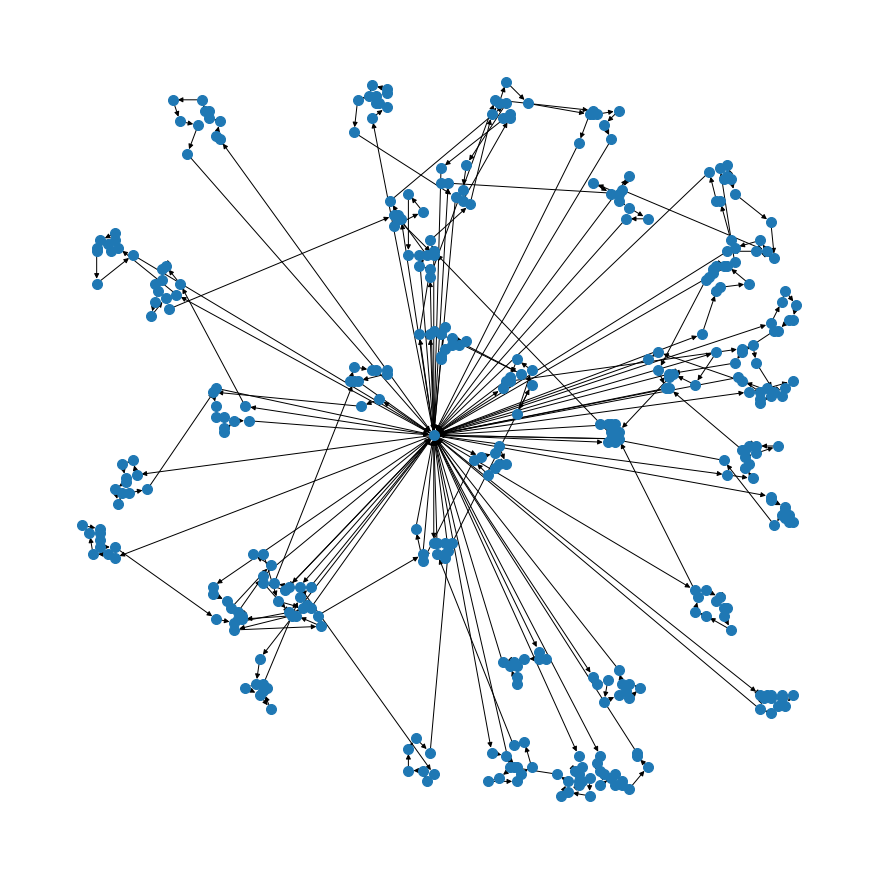

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

routes = """Route 1 : 102 69 222 159 304 71 113 211 59 253 364 
Route 2 : 357 77 74 394 68 14 288 6 178 327 386 312 43 
Route 3 : 94 54 180 179 146 268 79 339 34 230 260 329 
Route 4 : 310 165 262 400 379 319 8 81 197 246 84 308 
Route 5 : 387 278 78 231 188 125 225 323 224 41 
Route 6 : 332 216 358 195 285 18 238 334 100 
Route 7 : 397 72 203 365 341 207 187 200 119 232 42 106 
Route 8 : 186 154 381 202 342 309 118 21 346 45 
Route 9 : 292 226 109 172 26 350 282 352 40 183 123 75 228 273 
Route 10 : 17 326 214 355 117 247 162 320 168 283 289 158 104 227 
Route 11 : 105 155 395 361 272 306 377 124 2 347 376 
Route 12 : 286 88 217 209 185 10 152 336 297 163 
Route 13 : 343 269 64 208 145 318 175 3 184 99 354 
Route 14 : 5 160 337 330 143 215 46 147 153 89 166 258 
Route 15 : 114 348 235 388 281 129 263 176 137 384 44 36 
Route 16 : 303 144 24 93 229 204 295 103 220 122 86 139 
Route 17 : 335 385 199 82 296 359 254 293 60 53 313 315 
Route 18 : 322 221 284 351 191 349 130 372 91 344 
Route 19 : 63 121 233 173 161 120 134 107 
Route 20 : 366 150 83 193 19 55 50 383 131 261 213 294 
Route 21 : 324 156 133 210 382 338 256 205 270 151 58 
Route 22 : 23 371 38 333 111 194 363 251 316 276 142 356 80 
Route 23 : 374 181 389 1 116 127 245 65 62 32 264 
Route 24 : 298 87 39 67 307 396 242 259 51 
Route 25 : 112 135 70 302 201 25 96 49 353 
Route 26 : 301 280 392 169 237 321 291 16 136 317 265 73 
Route 27 : 33 52 380 85 328 177 95 30 
Route 28 : 375 149 101 206 257 300 13 15 76 311 7 241 
Route 29 : 360 12 314 279 90 196 399 132 22 140 
Route 30 : 97 255 29 157 47 299 305 219 198 249 28 
Route 31 : 287 31 362 108 248 171 243 239 192 128 27 393 
Route 32 : 189 174 390 271 244 57 48 345 98 250 234 
Route 33 : 267 141 252 370 274 138 170 4 190 275 240 9 212 
Route 34 : 56 182 236 61 218 11 369 110 35 223 290 
Route 35 : 92 266 398 66 277 325 368 37 20 331 
Route 36 : 126 115 340 373 167 148 378 164 367 391""".split('\n')
routes = [[int(x) for x in route.strip().split(' ')[3:]] for route in routes]
warehouse_pos = [warehouse_x, warehouse_y]
def draw_route(warehouse_pos, customers_x, customers_y, routes):
    G=nx.DiGraph()
    all_node_pos = [warehouse_pos] + [[x, y] for x,y in zip(customers_x, customers_y)]
    for i, node_pos in enumerate(all_node_pos):
        G.add_node(i, pos=(node_pos[0], node_pos[1]))
    for route in routes:
        cur_node = 0
        for node in route:
            G.add_edge(cur_node, node)
            cur_node = node
        G.add_edge(cur_node, 0)
    plt.figure(1,figsize=(12,12)) 
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, node_size=100)
    plt.show()


draw_route(warehouse_pos, customers_x, customers_y, routes)


In [8]:
import pandas as pd
import math
import numpy as np
from pulp import *

def distance(pos1, pos2):
    return math.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)

def get_distance_matrice(node_pos):
    node_num = len(node_pos)
    distance_matrix = np.zeros((node_num, node_num))
    for i, node1 in enumerate(node_pos):
        for j in range(i+1, node_num):
            node2 = node_pos[j]
            distance_matrix[i, j] = distance_matrix[j, i] = distance(node1, node2)
    return distance_matrix


def tsp_solution(node_pos, time_windows, demand, capacity, service_time):
    if np.sum(demand) > capacity:
        return False, None
    node_num = len(node_pos)
    max_duration = time_windows[0][1]
    prob = LpProblem("Routing", LpMinimize)
    node_order = [f"{i}_{j}" for i in range(node_num) for j in range(node_num)]
    edge_vars = LpVariable.dicts("Agent", node_order, 0, 1, LpBinary)
    arrive_time_vars = LpVariable.dicts("Time", node_order, 0, max_duration)
    distance_matrix = get_distance_matrice(node_pos)
    # objective
    prob += lpSum([edge_vars[f"{i}_{j}"]*distance_matrix[i, j] for i in range(node_num) for j in range(node_num)])
    # prob += (lpSum([arrive_time_vars[f"0_{j}"] for j in range(node_num)]) == 0.0, "depot has no demand")
    # one and only one is selected
    for i in range(node_num):
        prob += (lpSum([edge_vars[f"{i}_{j}"] for j in range(node_num)]) == 1.0, f"node {i} must be visited exactly once")
        prob += (lpSum([edge_vars[f"{j}_{i}"] for j in range(node_num)]) == 1.0, f"node {i} must be chosen exactly once")

    # constraints.append(cp.sum(f_vars[:, i])+demand[i] == cp.sum(f_vars[i, :]))
    # constraints.append(f_vars[i][i] == 0)
    for i in range(node_num):
        prob += (arrive_time_vars[f"{i}_{i}"] == 0.0, f'node {i} no going back it itself')
        if i > 0:
            prob += (lpSum([arrive_time_vars[f"{i}_{j}"] for j in range(node_num)]) - service_time[i] == lpSum([arrive_time_vars[f"{j}_{i}"] for j in range(node_num)]),
                        f"node {i} in and out balance")
        prob += (lpSum([arrive_time_vars[f"{i}_{j}"] for j in range(node_num)]) >= time_windows[i][0],
                        f"node {i} ready time")
        prob += (lpSum([arrive_time_vars[f"{i}_{j}"] for j in range(node_num)]) <= time_windows[i][1],
                        f"node {i} due time")
        for j in range(node_num):
            # constraints.append(f_vars[i][j] <= (vehicle_capacity-demand[j])*edge_vars[i][j])
            prob += (arrive_time_vars[f"{i}_{j}"] <= (max_duration-service_time[j])*edge_vars[f"{i}_{j}"], 
                    f'node {i} to {j} spent time constraint')


    solver = getSolver('GUROBI_CMD', timeLimit=1000)
    prob.solve(solver)
    # prob.solve()
    print(LpStatus[prob.status], value(prob.objective))
    _route = np.zeros(node_num)
    _arrive_time = np.zeros(node_num)
    cur_node = 0
    for i in range(node_num):
        _route[i] = cur_node
        print(cur_node, '\n')
        print([arrive_time_vars[f"{cur_node}_{j}"].varValue for j in range(node_num)])
        for j in range(node_num):
            if edge_vars[f"{cur_node}_{j}"].varValue >= 0.9:
                _arrive_time[cur_node] = arrive_time_vars[f"{cur_node}_{j}"].varValue
                cur_node = j
                break
    return True, _route, _arrive_time

route = "0 383 252 147 341 329 269 335 271 388 69 249 398 197 93 373 241 208 148 11 280 258 41 116 343 312 118 130 86 52 270 6 247 40 70 164 131".split()
route = [int(x) for x in route]
columns = ["node_idx", "x", 'y', 'demand', 'ready_time', 'due_time', 'service_time']
node_pos = [[problem_instance[i, columns.index('x')], problem_instance[i, columns.index('y')]] for i in route]
time_windows = [[problem_instance[i, columns.index('ready_time')], problem_instance[i, columns.index('due_time')]] for i in route]
capacity = 700
demand = [problem_instance[i, columns.index('demand')] for i in route]
service_time = [problem_instance[i, columns.index('service_time')] for i in route]

_, _route, _arrive_time = tsp_solution(node_pos, time_windows, demand, capacity, service_time)
spent_time = 0.0
for i in _route:
    print(int(i), route[int(i)], _arrive_time[int(i)], time_windows[int(i)])
    spent_time += service_time[int(i)]


Using license file /opt/gurobi/gurobi.lic
Set parameter TimeLimit to value 1000
Set parameter LogFile to value gurobi.log

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Copyright (c) 2020, Gurobi Optimization, LLC

Read LP format model from file /tmp/045bba7d7a7647738f70697e7de87ebd-lp
Reading time = 0.01 seconds
OBJ: 1590 rows, 2738 columns, 10843 nonzeros
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1590 rows, 2738 columns and 10843 nonzeros
Model fingerprint: 0xcac14315
Variable types: 1369 continuous, 1369 integer (1369 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 4e+03]
Presolve removed 1055 rows and 1926 columns
Presolve time: 0.03s
Presolved: 535 rows, 812 columns, 2441 nonzeros
Variable types: 421 continuous, 391 integer (391 binary)

Root relaxation: objective 3.061826e+02, 747 iterations, 0.01 secon

In [2]:
problem_instance = """
    0     100        100          0          0       3693          0
    1      37         48         10        106        627         90
    2      42        100         30        493        958         90
    3     131         31         10       1972       2454         90
    4     108         13         20       1914       2283         90
    5      17        166         10       1603       2324         90
    6     147        134         20       2696       3255         90
    7      48        103         10        769       1242         90
    8     127        166         20       2124       2426         90
    9      50        181         20        721       1170         90
   10      19        156         10       2029       2501         90
   11     146        157         40       1387       1955         90
   12      93        166         10       1424       1970         90
   13     170         83         30       1869       2360         90
   14      79         13         20       1285       1738         90
   15      73        112         10         60        559         90
   16      87         87         10       2478       3000         90
   17     118         50         10       1845       2257         90
   18      79         70         20        628       1210         90
   19      67        102         40       1815       2148         90
   20      48        166         30        336        769         90
   21      45         88         30         56        586         90
   22      61        101         10        426        958         90
   23      54        175         20        613       1084         90
   24     126         39         10       1832       2211         90
   25     107         73         30         27        552         90
   26      42         75         20       1321       1983         90
   27      74        102         10        388        791         90
   28      72        118         20        838       1426         90
   29      65        135         20       1186       1656         90
   30      27         89         10       2313       2981         90
   31      84        133         10         36        482         90
   32     178         69         40       1518       2127         90
   33     127         46         20       2701       3267         90
   34      28         96         20        208        669         90
   35     100         47         20         53        650         90
   36      69        167         20         73        678         90
   37      98         59         10         41        391         90
   38      79         84         10       2320       2779         90
   39      61        174         10       1267       1799         90
   40     138        135         10       2818       3511         90
   41     170        156         10       1870       2460         90
   42     119        169         20       2003       2350         90
   43      66        192         20       2223       2709         90
   44     120         76         30       1165       1714         90
   45      29        171         20       2363       2939         90
   46      89         11         10       1420       2170         90
   47     170         64         20       1930       2517         90
   48     135        146         10       3148       3546         90
   49      85        134         20         37        685         90
   50      19        179         30        838       1306         90
   51      95        137         10        451       1030         90
   52     163        125         30       2518       3034         90
   53      30         54         30         83        498         90
   54      16         77         20       1258       1821         90
   55      28        168         20       2480       3008         90
   56      78        188         20       2674       3231         90
   57      27         83         20       2483       3003         90
   58     136         57         30       1268       1829         90
   59      59         98         10       1544       2220         90
   60     170         49         30        688       1223         90
   61     114        138         20       2838       3313         90
   62      78        154         10         58        719         90
   63      69        190         30       2079       2666         90
   64      60        171         20        194        705         90
   65     112         53         10       1918       2379         90
   66      99        123         10       2321       2859         90
   67      28         50         10        281        881         90
   68      97        163         20       1578       2007         90
   69     150        135         20        692       1142         90
   70     136        134         10       3000       3554         90
   71     120        153         10       2723       3216         90
   72      79         89         10       2801       3422         90
   73     162         44         20        371        765         90
   74     163         55         20       2518       3048         90
   75     103         91         20          9        407         90
   76      74         91         20       2978       3436         90
   77     126         31         20       2117       2499         90
   78      16        146         10       1950       2380         90
   79      84         20         10       2457       2897         90
   80      21         91         20       1766       2339         90
   81      37        162         20       2627       3246         90
   82      89        168         20       2975       3346         90
   83      72         10         20        893       1560         90
   84      55        160         10        484        821         90
   85      63        189         30       2326       2795         90
   86     164        124         20       2426       2943         90
   87      20         96         20       1581       2153         90
   88      82         88         20       2591       3076         90
   89      76        157         20         61        606         90
   90      74        196         30       2648       3059         90
   91      85         14         10       2150       2637         90
   92      77         86         20       2218       2694         90
   93     142        141         20        989       1407         90
   94     119         66         10        819       1489         90
   95       7        176         10       1574       1963         90
   96      92         55         20       2466       3063         90
   97     168         43         10        644       1073         90
   98      89        113         10       2434       2954         90
   99      98         85         30       2856       3277         90
  100      46         99         10        664       1157         90
  101      62        120         30        729       1335         90
  102      93          1         20       1698       2280         90
  103     144         58         30       1201       1698         90
  104      20         54         20        468        893         90
  105      32        191         10        113        817         90
  106     143         72         20       2879       3283         90
  107      68        190         20       2055       2508         90
  108     140         51         10       1492       2015         90
  109     119        130         20       3141       3568         90
  110      37        195         10        201        785         90
  111      29        163         30       2609       3068         90
  112     120         70         10       1039       1457         90
  113      12        186         10       1327       1815         90
  114     118         59         10        700       1232         90
  115      90         74         10         27        456         90
  116     165        151         20       1737       2211         90
  117     125         72         20       1133       1553         90
  118     177        122         30       2206       2774         90
  119      64         78         10        468        950         90
  120      67         60         10       1312       1753         90
  121     167         55         30       2410       2788         90
  122     173         56         20        978       1312         90
  123     179         78         20       1849       2180         90
  124      83         74         40        897       1520         90
  125     140         70         30       1400       1888         90
  126      81        191         20       2843       3250         90
  127     101         37         30        227        622         90
  128      34        182         20        578        976         90
  129      99         61         20        470        884         90
  130     168        126         20       2455       2726         90
  131     139        131         20       3048       3468         90
  132     134         46         20       1666       1996         90
  133      66         78         30        336        899         90
  134      71        189         10       1920       2457         90
  135      70        185         20       1786       2403         90
  136      16         78         30       2105       2580         90
  137      57         73         30         50        556         90
  138      92         39         10       3011       3480         90
  139       5         58         20        859       1268         90
  140      75         61         20        575       1064         90
  141     186         50         20       1277       1783         90
  142      14        199         30       1245       1690         90
  143      80        139         30       1376       1869         90
  144     110         72         10         76        705         90
  145      40         87         20       2612       3035         90
  146     155         38         10        188        750         90
  147     155        108         20         55        678         90
  148     152        149         20       1684       2057         90
  149      55        195         20        839       1449         90
  150      86        100         10       3110       3589         90
  151      36        107         20       1003       1580         90
  152     103        148         20        773       1279         90
  153      29         88         10       2153       2744         90
  154      32         93         20         86        601         90
  155      79        132         20       1891       2298         90
  156      25        182         10        698       1251         90
  157      25        187         30       1073       1463         90
  158      23        102         30       2254       2832         90
  159     128         80         10       1361       1715         90
  160     165         62         20       2237       2585         90
  161      34         84         10       2714       3149         90
  162      82        100         10         18        594         90
  163     162         37         40        453        876         90
  164     138        132         10       3185       3554         90
  165      65        182         20       1144       1725         90
  166      53        168         20         82        441         90
  167     114         55         10       2510       2887         90
  168      24        164         30       2121       2608         90
  169      74          5         20       1149       1676         90
  170     109         73         10         80        519         90
  171     102        146         10        552       1314         90
  172     144         38         30        964       1482         90
  173      93         11         20       1650       2127         90
  174      73        106         10        226        764         90
  175      51        190         30        102        758         90
  176     106        113         30       2827       3333         90
  177      81         80         10        149        690         90
  178     138         22         30        752       1299         90
  179      69        173         40       1580       2045         90
  180      75         18         30        822       1253         90
  181     166         55         10       2428       2953         90
  182      89         68         10        863       1357         90
  183     126         59         20       1625       2093         90
  184      88        137         10       1537       2088         90
  185      99        152         40        928       1521         90
  186     178         54         20       1004       1657         90
  187     132         51         20       1487       1984         90
  188     100        147         10        623       1060         90
  189      36         96         10        255        818         90
  190       6         59         20        897       1412         90
  191     102         62         30        210        778         90
  192      55        188         30         98        334         90
  193     135         54         30       1473       1810         90
  194       6         66         20       1011       1674         90
  195      88        116         30       2595       3168         90
  196      29         75         20       1535       1975         90
  197     143        140         10        871       1344         90
  198      15        181         20        916       1417         90
  199     130         42         30       1734       2118         90
  200      17         99         20       1576       1969         90
  201     182         68         10       1469       1988         90
  202      27        187         30       1115       1604         90
  203      40         34         10        209        733         90
  204      57        183         10       1019       1653         90
  205      64        140         20       1291       1741         90
  206       2        178         10       1526       1821         90
  207      34         89         20       2248       2840         90
  208     149        149         20       1304       1840         90
  209     147        158         10       2463       2875         90
  210     110        150         20        823       1423         90
  211      83        149         20         51        632         90
  212      42        105         20        963       1426         90
  213      83        108         10         18        360         90
  214      20         78         20       1723       2141         90
  215      38         85         20       2507       2954         90
  216     101         74         30         26        486         90
  217      82        128         20       1994       2577         90
  218      73        110         20        164        639         90
  219      81        136         20       1752       2248         90
  220      91         14         20       2060       2536         90
  221      96         62         10       2571       3155         90
  222     130         47         10         60        528         90
  223      14        163         30       1842       2274         90
  224      21         56         40        510       1035         90
  225      88         41         10         60        428         90
  226      20         92         20       1813       2108         90
  227      73         20         10        698       1190         90
  228      95         18         30       1965       2438         90
  229      17         87         10       1851       2444         90
  230     123         32         30       2171       2631         90
  231     124        170         10       2119       2621         90
  232      84        141         30       1507       1926         90
  233     116         44         20       2388       2805         90
  234     133        162         10       2477       3071         90
  235      74         31         10        307        572         90
  236     107         23         20        372        870         90
  237      25        102         20       1259       1891         90
  238      97         71         10         29        460         90
  239      83        147         20         59        403         90
  240      38         94         10         78        418         90
  241     149        146         10       1184       1774         90
  242      93        117         40       2988       3390         90
  243     124        154         10       2703       3049         90
  244     115         40         20       2241       2764         90
  245      84        136         20       1619       2194         90
  246      88        111         20       2559       3014         90
  247     143        135         10       2807       3331         90
  248     143         30         30       1009       1240         90
  249     148        139         20        828       1196         90
  250      68         69         30       1074       1555         90
  251      97        157         20       1277       1918         90
  252     146        113         20         47        678         90
  253     118          9         10        537       1105         90
  254     125         16         10        556       1286         90
  255      81         92         20       2728       3308         90
  256     148         57         10         64        586         90
  257      89         27         20       2674       3060         90
  258     165        157         20       1819       2321         90
  259      70         89         20       2051       2667         90
  260      25        101         10       1207       1762         90
  261       6         95         10       2094       2539         90
  262      89         80         20         62        580         90
  263      76         15         20        871       1390         90
  264       3         56         20        688       1254         90
  265      82         48         30       2276       2862         90
  266      81         89         20       2732       3118         90
  267      20         79         30       1761       2284         90
  268      30         75         10       1423       1865         90
  269     160        137         10        186        897         90
  270     150        130         20       2690       3070         90
  271     156        137         20        540        918         90
  272     169         54         10        729       1372         90
  273      13         90         20       1943       2494         90
  274      49         64         20       1182       1666         90
  275      39         99         20        597       1011         90
  276      91         43         10         57        605         90
  277      60        197         20       2441       2878         90
  278      15         69         20       1240       1643         90
  279     101        164         10       1685       2088         90
  280     153        161         20       1555       1982         90
  281      11         83         10       2016       2475         90
  282     127         55         20       2773       3392         90
  283      33        103         10       1177       1596         90
  284      43        101         30        828       1373         90
  285     175         70         20       1682       2149         90
  286     122        144         20       2816       3536         90
  287      68         16         10        625       1071         90
  288      93         32         20       2818       3297         90
  289     164         61         10       2261       2744         90
  290      79         31         10         72        715         90
  291      69        178         20       1741       2254         90
  292      86        155         30        214        859         90
  293      87         67         30        744       1292         90
  294      99         48         10       3091       3551         90
  295      72          8         20       1116       1521         90
  296     108         82         30         19        470         90
  297      69        121         20       1132       1502         90
  298      67         13         30        509       1001         90
  299      33         73         20       1510       1964         90
  300      68        176         10       1701       2109         90
  301     106        127         30       2234       2749         90
  302     106         60         10        573       1155         90
  303      35         90         10       2378       2893         90
  304      84         13         10       1356       1858         90
  305     133        168         10       2259       2680         90
  306      21         76         20       1637       2042         90
  307      67         89         30       1906       2625         90
  308      67         97         10       1953       2383         90
  309      69         40         10        187        894         90
  310      13        120         20       2136       2730         90
  311      68        173         30       1496       1946         90
  312     190        122         10       1969       2621         90
  313     104         59         10        524       1021         90
  314     117         53         20       2485       3099         90
  315      84         25         10       2455       3089         90
  316     109        169         10       1682       2290         90
  317     120         50         10       2648       3124         90
  318      52         79         20       2965       3454         90
  319      69         99         10       1888       2262         90
  320      91         39         10       2903       3405         90
  321     108         26         10        323        731         90
  322     116        171         20       1842       2324         90
  323      65        164         20         72        702         90
  324     106         83         20         18        440         90
  325      55         97         20         45        538         90
  326      39         79         10       2682       3161         90
  327      13        173         30       1580       2151         90
  328      95         29         10       2183       2729         90
  329     160        136         20        158        743         90
  330     105         55         20       2020       2470         90
  331     146         62         20         59        516         90
  332      73        196         20       2469       3056         90
  333      95        150         30        324        950         90
  334      26        169         20       2189       2732         90
  335     161        139         20        393        876         90
  336      77        126         20       1940       2442         90
  337      66         81         10        330        718         90
  338     132         36         20       1927       2310         90
  339     101        152         20       1024       1608         90
  340      94         75         20       2730       3202         90
  341     158        122         30        103        591         90
  342      81         20         20       2362       2805         90
  343     180        126         10       2186       2605         90
  344      47         76         30       2827       3400         90
  345      60         37         30        366        914         90
  346      35        185         10        511        858         90
  347      36        177         30        570       1175         90
  348      48        191         10        765       1328         90
  349     169         36         10        598        925         90
  350     177         45         30       1248       1611         90
  351      72        119         20       1063       1384         90
  352      26        107         20       1444       1897         90
  353      15         57         10        622       1114         90
  354      54         73         30       2967       3550         90
  355      68        152         30        146        712         90
  356      93         26         20       2696       3226         90
  357      40        101         10        376        891         90
  358     111         24         10        426       1003         90
  359      46        128         30        695       1153         90
  360     177         55         10        967       1511         90
  361     132        139         10       3109       3553         90
  362     101         62         40        362        807         90
  363      97        116         30       2776       3185         90
  364      81         83         20       2358       2924         90
  365     157         59         30       2624       3138         90
  366      91         49         10       2370       2967         90
  367      81         32         10         70        499         90
  368      47         80         10       2705       3335         90
  369     119         62         10        849       1271         90
  370      43         98         30        569       1066         90
  371     101         55         30         45        526         90
  372      31         63         30         78        642         90
  373     145        144         10       1079       1691         90
  374      56        192         20        979       1495         90
  375     101        158         20       1209       1615         90
  376      30         86         20       2567       3107         90
  377      33        188         30        351        830         90
  378     156         64         10       2776       3176         90
  379     154         44         30        129        617         90
  380     171         63         20       2070       2560         90
  381     139        169         30       2294       2836         90
  382     121         52         40       1660       2255         90
  383     139        102         10         39        562         90
  384      84         10         40       1513       1886         90
  385       7         63         10       1028       1470         90
  386     184         55         10       1401       1849         90
  387      58        168         20        513        988         90
  388     156        135         20        584       1058         90
  389     165         52         20       1033       1643         90
  390     128        141         10       2877       3554         90
  391      79        106         20         21        437         90
  392     102         56         30       2055       2622         90
  393      87        132         20       2087       2678         90
  394      23        172         10       2303       2805         90
  395      64        172         10       1359       1894         90
  396      82        104         10       2887       3585         90
  397      99        156         30       1273       1738         90
  398     146        142         10       1048       1537         90
  399      14         81         30       1892       2347         90
  400      79         19         10       2319       2664         90"""

problem_instance = np.array(problem_instance.split()).reshape(-1, len(columns)).astype(np.int)
problem_instance


/data/songlei/anaconda3/envs/maroenv/lib/python3.7/site-packages/ipykernel_launcher.py:404: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


array([[   0,  100,  100, ...,    0, 3693,    0],
       [   1,   37,   48, ...,  106,  627,   90],
       [   2,   42,  100, ...,  493,  958,   90],
       ...,
       [ 398,  146,  142, ..., 1048, 1537,   90],
       [ 399,   14,   81, ..., 1892, 2347,   90],
       [ 400,   79,   19, ..., 2319, 2664,   90]])